# Hamiltonian Equation for a Marketplace described as Energy

Assuming natural forces apply to the business of a Marketplace and that cash is conserved, then the total energy of the Marketplace is the sum of the Potential Energy in the Book, plus the Kinetic Energy of transactions, less Marketplace transaction costs, plus the sum of external forces that weigh on or lift up equity prices in the Book. Consistant with the conservation of energy, the sum of these energies will remain constant over time so that the change in Marketplace energy over time tau is 0. The first solution of the equation is momentum of the price of each equity while the second order solution will be the final value of each equity T(t<sub>f</sub>)

![](https://www.elmtreegarden.com/wp-content/uploads/2020/06/image-768x103.png)

U is business value</br>
Q is internal energy of business including cash</br>
W are costs of operations</br>
ϕi - ϕj  is potential produced by seller i and buyer j</br>
ϕi - ϕj = 1 / (Ti - Tj) is potential to Trade</br>
Ni, is number of units traded. It is a vector with length i.</br>

Let T(EQ(t)) be the market price of equity EQ at time t. The expected value of T, is market price. If either buyers or sellers place no bids, then T is unidentifiable and price volitility is maximum and N, shares traded, is zero. As many buyers and sellers 'crowd' the marketplace with bids, volitility, del T, will decline and N, shares traded, will increase.

This contest has given us data on the "Target" del T = dT/T. Actual price of the Equity k is T<sub>k</sub>. I'll need to consider how this affects the formulation of the Hamiltonian.

## Caliber of the Book's Price/Volume distribution S (T,N|<sub>H</sub>)

S (T,N|<sub>H</sub>) is read: "*Caliber of T and N given History H.*" Or the "*Caliber of the Book's price/volume distribution (buyers and sellers) over History H.*" Or **Book Caliber**.

As the system emerges into the "now", Book Caliber is the cross section area of the possible futures the system may take on consistant with the History. The book with most possible trading options will have the least volitility. With more choices of trades (bigger Caliber) the marketmaker is more likely to find optimal (Ta ~= Tb) conditions for trading. Low Book Caliber indicates few trading choices for the marketmaker and fewer options to find optimal trades. If log base 2 is used then S ** 2 is the number of choices the marketmaker will possess.

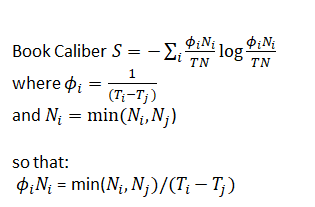

Book Caliber is measured directly from the Book of Orders for each History. del Q in the Hamiltonian above, then is the change in potential energy of the Book of Orders over a History.

del Q = del T S + T del S

## Kinetic Energy of Equity Sales

Conductance of business, N shares sold at price T, occurs when agreement on N and T exists. As (Ti - Tj) grows larger, trading declines, while Volume, N, is constrained to min(Ni, Nj). Kinetic energy of cash flow of trades in a History is the sum of T<sub>i</sub> * N<sub>i</sub>. This information comes from the Trades.

Sales is an exchange of potential energy for free energy. The Seller gets Free Energy (cash) and the Buyer obtains Potential Energy of the Equity. Energy of the trade is NT. No Energy is created. Energy changes form in the balance sheet of each trader.

## External Forces

Each book is influenced by many external forces. The price of equity A and equity B may have mutual information, this is to say each imparts a force on each other's price, or that dT1 = force(dT2). These forces may be modeled using a simple Bayesian Network, **BN**. The DAG of the model will indicate the forces on each Equity impossed by price changes in other Equities. 

In the equation above, X<sub>i</sub> is an external force on and equities price T causing a price change dx<sub>i</sub>. We have 130 Equities in our Book, so to see how each equity directly affects another's price, we need a 130 X 130 matrix to model these forces. (to be found with a BN)

Equities in Transportation will fall with higher energy costs while energy producers's price may increase (negative Pearson correlation). Industry Forces might be used to improve the model's performance. Clusters of Equities might be found that produce better price volitility predictors. Let's try to find about 10 Industies in the Book, and then see how Industry forces effect each equity. The model for this will require a 130 x 10 matrix of factors. (to be found from BN)

Taxes are another external force. Sellers of equities pay a Tax on Gains. This can be seen as "Work" produced by sellers too. But I see Taxes as an external force in this notebook, since I will assume each trader pays the same tax rate on gains. One Tax rate seems very reasionable.

Now let's first make some calculations on a book with one History (time_id=5) and one Equity (stock_id=20).

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import matplotlib.pyplot as plt
import glob
import os

In [ ]:
# Thanks Dan Watson for these handy parquet readers (https://www.kaggle.com/danwatson16/weighted-xgboost-with-stock-grouping-eda)

import tqdm as tqdm

def get_overall(book):
    total_df = pd.DataFrame()
    for i in tqdm.tqdm(book):
        temp_stock = int(i.split("=")[1])
        temp_relvol = get_stock_stat(i, temp_stock)
    #    print(temp_relvol)
        total_df = pd.concat([total_df, temp_relvol])
    return total_df

def trade_stock_stat(path, stock_id):
    trade =  pd.read_parquet(path)
    trade['stock_id'] = stock_id
    trade['trade_log_return'] = trade.groupby(['time_id'])['price'].apply(log_return).fillna(0)
    trade_features = ["price", "size", "order_count", "trade_log_return"] 
    return stock_stat

def merge_frames(train = True):
    if train:
        order_book_training = glob.glob('/kaggle/input/optiver-realized-volatility-prediction/book_train.parquet/*')
        total_df = get_overall(order_book_training)
        trade_training = glob.glob('/kaggle/input/optiver-realized-volatility-prediction/trade_train.parquet/*')
        total_trade = get_trade_overall(trade_training).drop(columns = ["seconds_in_bucket", "price", "size", "order_count", "trade_log_return"]).drop_duplicates()
        total_df = total_df.merge(total_trade, on = ["stock_id","time_id"], how = "left")
    else:
        # listing all test order books
        order_book_test = glob.glob('/kaggle/input/optiver-realized-volatility-prediction/book_test.parquet/*')
        test_df = get_overall(order_book_test)
        trade_test = glob.glob('/kaggle/input/optiver-realized-volatility-prediction/trade_test.parquet/*')
        total_test = get_trade_overall(trade_test).drop(columns = ["seconds_in_bucket", "price", "size", "order_count", "trade_log_return"]).drop_duplicates()
        total_df = test_df.merge(total_test, on = ["stock_id","time_id"], how = "left")
    return total_df

In [ ]:
def get_stock_stat(path, stock_id):
    df_book = pd.read_parquet(path) # order book for a stock id loaded
    
    df_book['N'] = df_book[['ask_size1','bid_size1']].min(axis=1)
    df_book['phi'] = 1/(df_book['ask_price1'] - df_book['bid_price1']) + 1/(df_book['ask_price2'] - df_book['bid_price2'])
    df_book['phiN'] = df_book['phi'] * df_book['N']
    df_book['S'] = (df_book.phiN * np.log(df_book.phiN)).cumsum()
    df_book['dS_dt'] = (df_book['S'] - df_book['S'].shift(1))
    df_book['dphi_dt'] = (df_book['phi'] - df_book['phi'].shift(1))
    
    # compute different vwap
    df_book['wap1'] = (df_book['bid_price1'] * df_book['ask_size1'] + df_book['ask_price1'] * df_book['bid_size1']) / (
                            df_book['bid_size1'] + df_book['ask_size1'])
    
    df_book['wap2'] = (df_book['bid_price2'] * df_book['ask_size2'] + df_book['ask_price2'] * df_book['bid_size2']) / (
                            df_book['bid_size2'] + df_book['ask_size2'])

    df_book['wap3'] = (df_book['bid_price2'] * df_book['bid_size2'] + df_book['ask_price2'] * df_book['ask_size2']) / (
                            df_book['bid_size2'] + df_book['ask_size2'])
    return wap
                            
    stock_stat['stock_id'] = stock_id

    return stock_stat

In [ ]:
#train = merge_frames()
#train

In [ ]:
train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
book_example = pd.read_parquet('../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id=20')
trade_example =  pd.read_parquet('../input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=20')
stock_id = '20'
book_example = book_example[book_example['time_id']==5]
book_example.loc[:,'stock_id'] = stock_id
trade_example = trade_example[trade_example['time_id']==5]
trade_example.loc[:,'stock_id'] = stock_id

In [ ]:
book_example

In [ ]:
book_example['N'] = book_example[['ask_size1','bid_size1']].min(axis=1)
book_example['phi'] = 1/(book_example['ask_price1'] - book_example['bid_price1'])

book_example['phiN'] = book_example['phi'] * book_example['N']
book_example['S'] = (book_example.phiN * np.log2(book_example.phiN)).cumsum()
book_example['dS_dt'] = (book_example['S'] - book_example['S'].shift(1))

fig, ax = plt.subplots()
ax.scatter(book_example.seconds_in_bucket,book_example.S)
ax.set_title("Book Caliber")
ax.set_xlabel("Time in seconds")
ax.set_ylabel("Caliber S")
fig.show()

In [ ]:
#plt.scatter(book_example.seconds_in_bucket,book_example['dS_dt'])

fig, ax = plt.subplots()
ax.scatter(book_example.seconds_in_bucket,book_example['dS_dt'])
ax.set_title("Book Caliber change")
ax.set_xlabel("Time in seconds")
ax.set_ylabel("Change in Caliber S")
fig.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(trade_example.seconds_in_bucket,(trade_example.price * trade_example['size']).cumsum())
ax.set_title("Book Sales: Total Kinetic Energy of the Book")
ax.set_xlabel("Time in seconds")
ax.set_ylabel("Dollars / kT")
fig.show()


In [ ]:
EF = 6 * (trade_example.price * trade_example['size']).sum()
print(EF, "Energy Flow per Hour / kT  where kT is equity Price")
print(book_example.phi.sum(), "Potential phi")
print((trade_example.price * trade_example['size']).sum()/book_example.phi.sum(), "Conductance")

In [ ]:
book = pd.merge(trade_example, book_example, on = 'seconds_in_bucket', how = 'outer')
book['Cond'] = (book.price * book['size'])/book.phi
plt.scatter(book.seconds_in_bucket, book.Cond)

In [ ]:
book

In [ ]:
from sklearn.metrics import r2_score
import glob
list_order_book_file_train = glob.glob('/kaggle/input/optiver-realized-volatility-prediction/book_train.parquet/*')

In [ ]:
plt.hist(trade_example.price * trade_example['size'], bins=50)


## Work in progress
Next Steps:
1. Make a BN using del T of each Equity for one History. Try to estimate forces between Equities.
2. Using all Histories identify Industry forces on each Equity. Try to find Tax burden.
3. Construct a Hamiltonian for each Equity. 
4. Solve for most likely price volitility given most recent History